In [1]:
import sys
import os.path
import numpy as np
import tensorflow as tf
import xarray as xr
import sys
sys.argv = sys.argv[:1]
import tensorflow as tf
#from layers.GradientHighwayUnit import GHU as ghu
#from layers.CausalLSTMCell import CausalLSTMCell as cslstm
from parflow_nn.preprocess_PF import create_feature_or_target_da
#from parflow_nn.write_nc import generate_nc_files
from parflow_nn.config import Config
from nets.PredPP import PredPP
#from layers.TensorLayerNorm import tensor_layer_norm

In [2]:
import os.path
import time
import numpy as np
import sys
import random
from data_provider import datasets_factory
from utils import preprocess
from utils import metrics

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.2.0
Eager execution: True


In [5]:
#tf.compat.v1.disable_eager_execution()

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
t0 = time.time()
c = Config('parflownn', 'parflow_nn/config.ini')
run_dir = '/home/hvtran/ParFlow-NN/washita_clm'
is_clm = True
#out_dir = generate_nc_files(run_dir, overwrite = False, is_clm = is_clm)
out_dir = '/home/hvtran/ParFlow-NN/washita_clm/nc_files'
t1 = time.time()
print('Creating nc file time: '+str(t1 - t0))

Creating nc file time: 0.0007410049438476562


In [8]:
# Normalization
def normalize_feature_da(feature_da, feature_names=None):
    """Normalize feature arrays, and optionally target array
    Args:
        feature_da: feature Dataset
        feature_names: Feature name strings
    Returns:
        da: Normalized DataArray
    """
    if feature_names is not None: # static inputs
        con_stats_norm = []
        for feati in feature_da:
            if len(np.unique(feati)) == 1:
                con_stats_norm.append(feati)
            else:
                meani = np.ma.mean(feati, axis = (2, 3))
                stdi = np.ma.std(feati, axis = (2, 3))
                meani[stdi == 0] = 0
                stdi[stdi == 0] = 1
                #broadcast back stdi
                stdi_broadcast = np.tile(stdi, (1, feati.shape[2], feati.shape[3], 1))
                stdi_broadcast = np.swapaxes(stdi_broadcast, 2, 3)
                stdi_broadcast = np.swapaxes(stdi_broadcast, 1, 2)
                #broadcast back meani
                meani_broadcast = np.tile(meani, (1, feati.shape[2], feati.shape[3], 1))
                meani_broadcast = np.swapaxes(meani_broadcast, 2, 3)
                meani_broadcast = np.swapaxes(meani_broadcast, 1, 2)
                feati_norm = (feati - meani_broadcast) / stdi_broadcast
                feati_norm = tf.conver_to_tensor(feati_norm, dtype = tf.float32)
                con_stats_norm.append(feati_norm)
        return con_stats_norm
    else: # forcing inputs and target
        forcing_mean = np.ma.mean(feature_da, axis = (0, 1, 2, 3))
        forcing_std = np.ma.std(feature_da, axis = (0, 1, 2, 3))
        forcing_mean[forcing_std == 0] = 0
        forcing_std[forcing_std == 0] = 1
        #broadcast back
        mean_broadcast = np.tile(forcing_mean, (1, feature_da.shape[1], feature_da.shape[2],
                                feature_da.shape[3], 1))
        std_broadcast = np.tile(forcing_std, (1, feature_da.shape[1], feature_da.shape[2],
                                feature_da.shape[3], 1))
        out_arr = (feature_da - mean_broadcast) / std_broadcast
        return tf.convert_to_tensor(out_arr, dtype = tf.float32)


In [9]:
# -----------------------------------------------------------------------------
FLAGS = tf.compat.v1.app.flags.FLAGS

# model
tf.compat.v1.app.flags.DEFINE_string('model_name', 'predrnn_pp',
                           'The name of the architecture.')
"""
tf.compat.v1.app.flags.DEFINE_string('pretrained_model', '/home/hvtran/ParFlow-NN/predrnn_pretrained/',
                           'file of a pretrained model to initialize from.')
tf.compat.v1.app.flags.DEFINE_string('pretrained_model_meta', '/home/hvtran/ParFlow-NN/predrnn_pretrained/model1.ckpt-300.meta',
                           'file of a pretrained model metadata file to initialize from.')
"""
tf.compat.v1.app.flags.DEFINE_string('pretrained_model', '',
                           'file of a pretrained model to initialize from.')
tf.compat.v1.app.flags.DEFINE_string('pretrained_model_meta', '',
                           'file of a pretrained model metadata file to initialize from.')
tf.compat.v1.app.flags.DEFINE_integer('seq_length', 24,
                            'total input and output length.')
tf.compat.v1.app.flags.DEFINE_integer('img_width', 41,
                            'input image width.')
tf.compat.v1.app.flags.DEFINE_integer('img_channel', 8,
                            'number of image channel.')
tf.compat.v1.app.flags.DEFINE_integer('target_channel', 123,
                            'number of target channel.')
tf.compat.v1.app.flags.DEFINE_integer('stride', 1,
                            'stride of a convlstm layer.')
tf.compat.v1.app.flags.DEFINE_integer('filter_size', 5,
                            'filter of a convlstm layer.')
tf.compat.v1.app.flags.DEFINE_string('num_hidden', '8,16,32,64,64,64,64,64,48',
                           'COMMA separated number of units in a convlstm layer.')
tf.compat.v1.app.flags.DEFINE_integer('patch_size', 1,
                            'patch size on one dimension.')
tf.compat.v1.app.flags.DEFINE_boolean('layer_norm', True,
                            'whether to apply tensor layer norm.')
# optimization
tf.compat.v1.app.flags.DEFINE_float('lr', 0.001,
                          'base learning rate.')
tf.compat.v1.app.flags.DEFINE_boolean('reverse_input', True,
                            'whether to reverse the input frames while training.')
tf.compat.v1.app.flags.DEFINE_integer('batch_size', 1,
                            'batch size for training.')
tf.compat.v1.app.flags.DEFINE_integer('max_iterations', 300,
                            'max num of steps.')
tf.compat.v1.app.flags.DEFINE_integer('display_interval', 1,
                            'number of iters showing training loss.')
tf.compat.v1.app.flags.DEFINE_integer('test_interval', 2000,
                            'number of iters for test.')
tf.compat.v1.app.flags.DEFINE_integer('snapshot_interval', 10000,
                            'number of iters saving models.')


In [10]:
run_name, is_clm = 'washita_clm', True

static_file = os.path.join(out_dir, f'{run_name}_static.nc')
forcing_file = os.path.join(out_dir, f'{run_name}_forcings.nc')
target_satur_file = os.path.join(out_dir, f'{run_name}_satur.nc')
target_press_file = os.path.join(out_dir, f'{run_name}_press.nc')

if is_clm:
    target_clm_file = os.path.join(out_dir, f'{run_name}_clm.nc')


In [11]:
# Static data
static_input = xr.open_dataset(static_file)
static_feature_da, static_feature_names = create_feature_or_target_da(
            static_input,
            ['prev_press','slope_x','slope_y','perm','poros',
             'rel_perm_alpha','rel_perm_N',
             'satur_alpha','satur_N','satur_sres','satur_ssat',
             'tensor_x','tensor_y','tensor_z','spec_storage','mannings'],
            0,
            'feature',
            flx_same_dt=True
    )

t2 = time.time()
####reshape feature
#static_feature_da = reshape_da(static_feature_da)
print('time to read static data: '+str(np.around(t2-t1,3))+' s')

## reduce input
t3 = time.time()
one_layer_feats = ['slope_x','slope_y','spec_storage','mannings',
                  'tensor_x','tensor_y','tensor_z']
new_static_feature_da = []
new_static_names = []
for ii,fname in enumerate(static_feature_names.data):
    if fname.split('_lev')[0] in one_layer_feats:
        if int(fname[-2:]) == 0:
            new_static_feature_da.append(static_feature_da[:,ii,:,:])
            new_static_names.append(fname)
        else:
            continue
    else:
        new_static_feature_da.append(static_feature_da[:,ii,:,:])
        new_static_names.append(fname)

new_static_feature_da = np.stack(new_static_feature_da,axis=0)
new_static_feature_da = np.swapaxes(new_static_feature_da,0,1)
new_static_feature_da = np.swapaxes(new_static_feature_da,1,2)
new_static_feature_da = np.swapaxes(new_static_feature_da,2,3)
t4 = time.time()
print('time to reduce static input data: '+str(np.around(t4-t3,3))+' s')


time to read static data: 0.73 s
time to reduce static input data: 0.186 s


In [12]:
# Forcing data
forcing_input = xr.open_dataset(forcing_file)

forcing_feature_da, forcing_feature_names = create_feature_or_target_da(
    forcing_input,
    ['forcings'],
    0,
    'feature',
    flx_same_dt=True
)

# Add channel dimension
if is_clm:
    forcing_feature_da = forcing_feature_da.data[:]
    forcing_feature_da = np.swapaxes(forcing_feature_da, 1, 2)
    forcing_feature_da = np.swapaxes(forcing_feature_da, 2, 3)
    forcing_feature_da = np.repeat(forcing_feature_da,
                           repeats=[2] + [1] * (forcing_feature_da.shape[0] - 1),
                           axis=0)  # duplicate the first row
    forcing_feature_da = forcing_feature_da[np.newaxis, ...]
else:
    forcing_feature_da = forcing_feature_da.data[:, 0, :, :]
    forcing_feature_da = forcing_feature_da[..., np.newaxis]
    forcing_feature_da = forcing_feature_da[np.newaxis, ...]


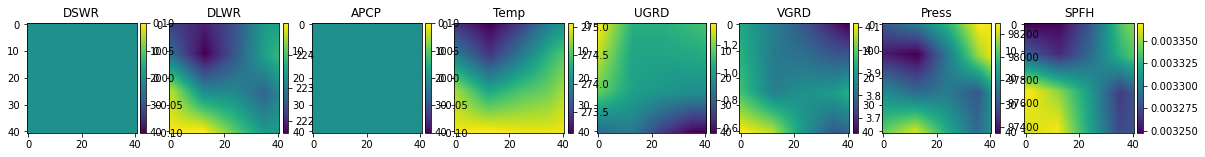

In [13]:
i = 3000
fig, axs = plt.subplots(1,8,figsize=(20, 18))
ax0 = axs[0]
im0 = ax0.imshow(forcing_feature_da[0, i, :, :, 0])
ax0.set_title('DSWR')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax0 = axs[1]
im0 = ax0.imshow(forcing_feature_da[0, i, :, :, 1])
ax0.set_title('DLWR')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax0 = axs[2]
im0 = ax0.imshow(forcing_feature_da[0, i, :, :, 2])
ax0.set_title('APCP')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax0 = axs[3]
im0 = ax0.imshow(forcing_feature_da[0, i, :, :, 3])
ax0.set_title('Temp')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax0 = axs[4]
im0 = ax0.imshow(forcing_feature_da[0, i, :, :, 4])
ax0.set_title('UGRD')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax0 = axs[5]
im0 = ax0.imshow(forcing_feature_da[0, i, :, :, 5])
ax0.set_title('VGRD')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax0 = axs[6]
im0 = ax0.imshow(forcing_feature_da[0, i, :, :, 6])
ax0.set_title('Press')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax0 = axs[7]
im0 = ax0.imshow(forcing_feature_da[0, i, :, :, 7])
ax0.set_title('SPFH')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

plt.show()

In [14]:
# Target outputs
target_press_input_xr = xr.open_dataset(target_press_file)
target_satur_input_xr = xr.open_dataset(target_satur_file)
if is_clm:
    target_clm_input_xr = xr.open_dataset(target_clm_file)
    target_clm = np.repeat(target_clm_input_xr.clm,
                           repeats=[2]+[1]*(target_clm_input_xr.clm.shape[0] - 1),
                           axis=0) #duplicate the first row
    target_da = np.concatenate([target_press_input_xr.press,
                        target_satur_input_xr.satur,
                        target_clm], axis = 1)
    target_da = target_da[np.newaxis, ...]
else:
    target_dataset = target_press_input_xr.merge(target_satur_input_xr)
    target_da, target_names = create_feature_or_target_da(
        target_dataset,
        ['press', 'satur'],
        0,
        'target',
        1,
        flx_same_dt=True
    )

    target_da = target_da.data[np.newaxis, ...]

target_da = np.swapaxes(target_da, 2, 3)
target_da = np.swapaxes(target_da, 3, 4)


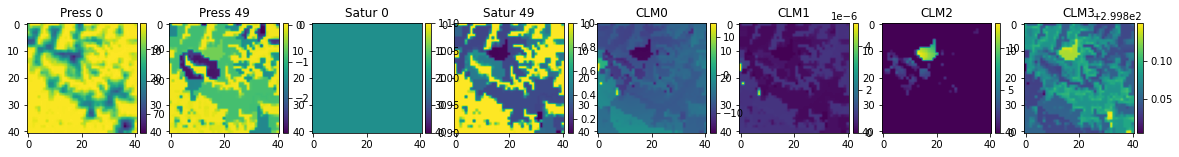

In [15]:
i = 3000
fig, axs = plt.subplots(1,8,figsize=(20, 18))
ax0 = axs[0]
im0 = ax0.imshow(target_da[0, i, :, :, 0])
ax0.set_title('Press 0')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax0 = axs[1]
im0 = ax0.imshow(target_da[0, i, :, :, 49])
ax0.set_title('Press 49')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax0 = axs[2]
im0 = ax0.imshow(target_da[0, i, :, :, 50])
ax0.set_title('Satur 0')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax0 = axs[3]
im0 = ax0.imshow(target_da[0, i, :, :, 99])
ax0.set_title('Satur 49')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax0 = axs[4]
im0 = ax0.imshow(target_da[0, i, :, :, 100])
ax0.set_title('CLM0')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax0 = axs[5]
im0 = ax0.imshow(target_da[0, i, :, :, 105])
ax0.set_title('CLM1')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax0 = axs[6]
im0 = ax0.imshow(target_da[0, i, :, :, 110])
ax0.set_title('CLM2')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax0 = axs[7]
im0 = ax0.imshow(target_da[0, i, :, :, 117])
ax0.set_title('CLM3')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

plt.show()

In [16]:
list_days = np.arange(0, 365, 30)
forcings = []
targets = []
for ii,timei in enumerate(list_days[:-1]):
    forcings.append(forcing_feature_da[0, 24*timei: 24*list_days[ii + 1], :, :, :])
    targets.append(target_da[0, 24*timei: 24*list_days[ii + 1], :, :, :])

In [17]:
#forcing_feature_train = np.stack(forcings)
#target_train = np.stack(targets)
forcing_feature_train = forcing_feature_da[:, :24*2, :, :, :]
target_train = target_da[:, :24*2, :, :, :]

In [18]:
#Normalization
forcing_norm_train = normalize_feature_da(forcing_feature_train)
target_norm_train = normalize_feature_da(target_train)

In [19]:
@tf.function
def reshape_patch(img_tensor, patch_size):
    batch_size = tf.shape(img_tensor)[0]
    seq_length = tf.shape(img_tensor)[1]
    img_height = tf.shape(img_tensor)[2]
    img_width = tf.shape(img_tensor)[3]
    num_channels = tf.shape(img_tensor)[4]
    a = tf.reshape(img_tensor, [batch_size, seq_length,
                                int(img_height/patch_size), patch_size,
                                int(img_width/patch_size), patch_size,
                                num_channels])
    b = tf.transpose(a, [0,1,2,4,3,5,6])
    patch_tensor = tf.reshape(b, [batch_size, seq_length,
                                  int(img_height/patch_size),
                                  int(img_width/patch_size),
                                  patch_size*patch_size*num_channels])
    return patch_tensor


In [ ]:
t0 = time.time()
patch_size = tf.Variable(FLAGS.patch_size)
ims = reshape_patch(forcing_norm_train, patch_size)
tars = reshape_patch(target_norm_train, patch_size)
tars = tars[:, :, :, :, :50]
t1 = time.time()
print('reshape time: '+str(t1 - t0))

In [21]:
lr = FLAGS.lr
num_hidden = [16, 16, 32, 32, 64, 64, 128, 128, 128, 48]
print(num_hidden)
num_layers = len(num_hidden)
delta = 0.00002
base = 0.99998
eta = 1
reverse_input = True

[16, 16, 32, 32, 64, 64, 128, 128, 128, 48]


In [22]:

import tensorflow as tf
from layers.GradientHighwayUnit import GHU as ghu
from layers.CausalLSTMCell import CausalLSTMCell as cslstm


In [91]:
class PredPP(tf.keras.layers.Layer):
    def __init__(self, shape, output_channels, num_layers, 
                 num_hidden, filter_size, seq_length, tln=True,
                 stride=1):
        super(PredPP, self).__init__()
        self.lstm = []
        self.cell = []
        self.hidden = []
        self.shape = shape
        
        self.seq_length = seq_length
        self.num_layers = num_layers
        
        for i in range(num_layers):
            if i == 0:
                num_hidden_in = num_hidden[num_layers-1]
            else:
                num_hidden_in = num_hidden[i-1]
            self.new_cell = cslstm('lstm_'+str(i+1),
                              filter_size,
                              num_hidden_in,
                              num_hidden[i],
                              shape,
                              tln=tln)
            self.lstm.append(self.new_cell)
            self.cell.append(None)
            self.hidden.append(None)

        self.gradient_highway = ghu('highway', filter_size, num_hidden[0], tln=tln)
        self.conv2d = tf.keras.layers.SeparableConv2D(filters=output_channels,
                                         kernel_size=1,
                                         strides=1,
                                         padding='same',
                                         name="back_to_pixel")
        
        self.conv2d_pre = tf.keras.layers.SeparableConv2D(filters=3,
                                                         kernel_size=5,
                                                         strides=1,
                                                         padding='same',
                                                         name="before_MobileNET")
        self.mobile_net = tf.keras.applications.MobileNet(input_shape = (shape[2], shape[3], 3),
                                                         include_top = False,
                                                         weights = '/home/hvtran/ParFlow-NN/saved_models/mobilenet_1_0_224_tf_no_top.h5')
        for layer in self.mobile_net.layers:
            layer.trainable = False
        self.conv2d_post = tf.keras.layers.SeparableConv2D(filters=num_hidden[num_layers-1],
                                                             kernel_size=5,
                                                             strides=1,
                                                             padding='same',
                                                             name="after_MobileNET")
        
    def call(self, input):
        images = input['images']
        init_mem = input['init_mem']
        gen_images = []
        if init_mem is not None:
            tmp_x = self.conv2d_pre(init_mem)
            ####Mobile Net
            block1 = tf.keras.layers.UpSampling2D(size=(int(self.shape[2]/5),int(self.shape[3]/5)))(self.mobile_net.get_layer("conv_pw_5_relu").output)
            block1 = tf.image.resize_with_pad(block1, self.shape[2], self.shape[3])
            tmp_model = tf.keras.models.Model(self.mobile_net.input, block1)
            tmp_x = tmp_model(tmp_x)
            ####
            mem = self.conv2d_post(tmp_x)
        else:
            mem = None
        z_t = None
        for t in range(self.seq_length - 1):
            inputs = images[:,t]

            self.hidden[0], self.cell[0], mem = self.lstm[0](inputs, self.hidden[0], self.cell[0], mem)
            z_t = self.gradient_highway(self.hidden[0], z_t)
            self.hidden[1], self.cell[1], mem = self.lstm[1](z_t, self.hidden[1], self.cell[1], mem)

            for i in range(2, self.num_layers):
                self.hidden[i], self.cell[i], mem = self.lstm[i](self.hidden[i-1], self.hidden[i], self.cell[i], mem)

            x_gen = self.conv2d(self.hidden[self.num_layers-1])
            gen_images.append(x_gen)

        gen_images = tf.stack(gen_images)
        # [batch_size, seq_length, height, width, channels]
        gen_images = tf.transpose(gen_images, [1,0,2,3,4])
        return gen_images
    
    def get_config(self):
        
        config = super().get_config().copy()
        config.update({
            'lstm': self.lstm,
            'cell': self.cell,
            'hidden': self.hidden,
            'shape': self.shape,
            'seq_length': self.seq_length,
            'num_layers': self.num_layers,
            'gradient_highway': self.gradient_highway,
            'conv2d': self.conv2d,
        })
        
        return config

In [92]:
# Optimizer and loss function
ae_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
# MSE works here best
loss_func = tf.keras.losses.MeanSquaredError()

t0 = time.time()
model = tf.keras.models.Sequential()
mylayer = PredPP(ims.get_shape().as_list(), tars.shape[4], 
                num_layers, num_hidden,
                FLAGS.filter_size,
                ims.shape[1],
                True)

model.add(mylayer)
t1 = time.time()
print('time to load model: '+str(t1-t0))

t0 = time.time()
model.compile(optimizer = ae_optimizer, loss = loss_func, metrics = 'mse')
t1 = time.time()
print('time to compile model: '+str(t1-t0))

time to load model: 0.8824646472930908
time to compile model: 0.008828401565551758


In [93]:
#learning_rate = 1e-2
#ae_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

def train_step(input, init_stat, target, learning_rate):
    with tf.GradientTape() as ae_tape:
        prediction = model({'images':input, 'init_mem':init_stat})
        # Calculate loss
        loss = loss_func(target[:, 1:], prediction)
    # Get the encoder and decoder variables
    trainable_vars = model.trainable_variables 
    # Calculate gradient          
    ae_grads = ae_tape.gradient(loss, trainable_vars)
    # And then apply the gradient to change the weights
    ae_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    ae_optimizer.apply_gradients(zip(ae_grads, trainable_vars))

    # Loss is returned to monitor it while training
    return loss, ae_optimizer

In [94]:
t0 = time.time()
for ii in range(51):
    loss, ae_optimizer = train_step(ims, new_static_feature_da, tars, 1e-2)
    if reverse_input:
        ims_rev = ims[:, ::-1]
        tars_rev = tars[:, ::-1]
        tmp_loss, _ = train_step(ims_rev, new_static_feature_da, tars_rev, 1e-2)
        loss += tmp_loss
        loss = loss/2
    if ii % 10 == 0:
        t1 = time.time()
        elapsed_time = t1 - t0
        t0 = time.time()
        print("loss {:1.6f}, time step {:1.0f}, elapsed_time {:2.4f} s".format(loss.numpy(), ii, elapsed_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

loss 0.979828, time step 0, elapsed_time 13.5681 s
loss 0.725323, time step 10, elapsed_time 96.8892 s
loss 0.603529, time step 20, elapsed_time 96.9377 s
loss 0.546542, time step 30, elapsed_time 97.1030 s
loss 0.456420, time step 40, elapsed_time 97.5204 s
loss 0.333463, time step 50, elapsed_time 97.6717 s


In [95]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pred_pp_7 (PredPP)           multiple                  4806674   
Total params: 4,806,674
Trainable params: 1,577,810
Non-trainable params: 3,228,864
_________________________________________________________________


In [62]:
model.save('test')

INFO:tensorflow:Assets written to: test/assets


In [63]:
new_model = tf.keras.models.load_model("test", custom_objects={"PredPP": PredPP})

TypeError: __init__() missing 4 required positional arguments: 'shape', 'output_channels', 'num_hidden', and 'filter_size'

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pred_pp (PredPP)             multiple                  1542698   
Total params: 1,542,698
Trainable params: 1,542,698
Non-trainable params: 0
_________________________________________________________________


In [37]:
forcing_feature_test = forcing_feature_da[:, :24*2 :, :, :]
target_test = target_da[:, :24*2, :, :, :50]
#Normalization
forcing_norm_test = normalize_feature_da(forcing_feature_test)
target_norm_test = normalize_feature_da(target_test)
ims_test = reshape_patch(forcing_norm_test, FLAGS.patch_size)
tars_test = reshape_patch(target_norm_test, FLAGS.patch_size)

In [38]:
t0 = time.time()
predict = model(ims_test)
t1 = time.time()
print('predict time: '+str(t1-t0))

predict time: 1.9875216484069824


In [39]:
# De-normalization
target_mean = np.ma.mean(target_test, axis = (0, 1, 2, 3))
target_std = np.ma.std(target_test, axis = (0, 1, 2, 3))
#broadcast back
target_mean_broadcast = np.tile(target_mean, (1, target_test.shape[1], target_test.shape[2],
                                target_test.shape[3], 1))
target_std_broadcast = np.tile(target_std, (1, target_test.shape[1], target_test.shape[2],
                            target_test.shape[3], 1))

result_denorm = (predict * target_std_broadcast[:, 1:, :, :, :50]) + target_mean_broadcast[:, 1:, :, :, :50]

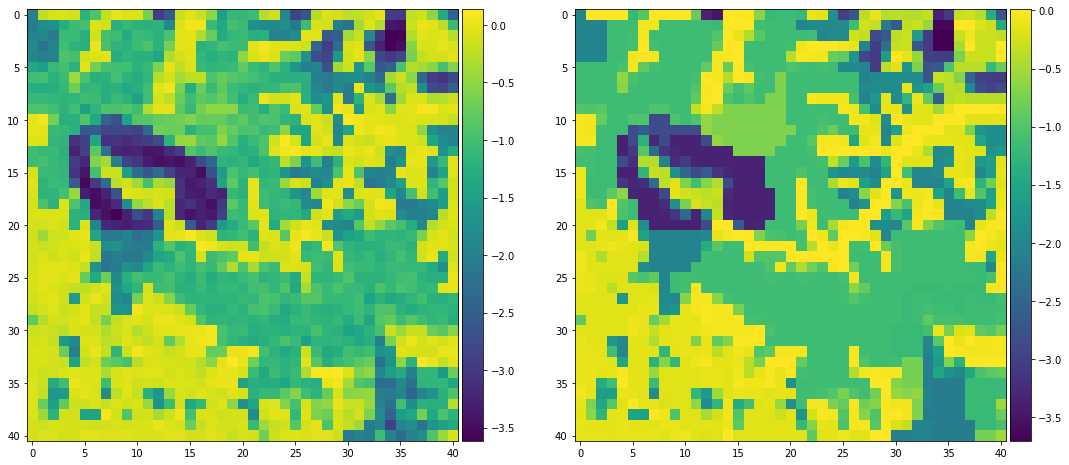

In [42]:
fig, axs = plt.subplots(1,2, figsize = (18, 18))

ax0 = axs[0]
im0 = ax0.imshow(result_denorm[0, 46, :, :, 49])
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax1 = axs[1]
im1 = ax1.imshow(target_test[0, 47, :, :, 49])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im1, cax = cax, orientation = 'vertical')

plt.show()

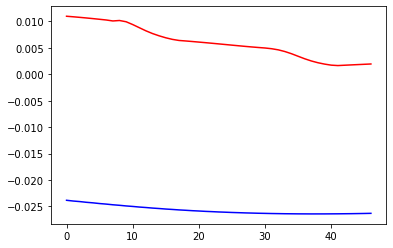

In [43]:
plt.plot(result_denorm[0, :, 10, 36, 49], 'b')
plt.plot(target_test[0, 1:, 10, 36, 49], 'r')
plt.show()